In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.1.0


In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [4]:
import time
from datetime import datetime

In [5]:
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

In [6]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
print(zarr_dataset.agents)
print(zarr_dataset.agents.shape)
n = zarr_dataset.agents.shape

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>
(1893736,)


In [8]:
# helper to convert a timedelta to a string (dropping milliseconds)
def deltaToString(delta):
    timeObj = time.gmtime(delta.total_seconds())
    return time.strftime('%H:%M:%S', timeObj)

class ProgressBar:
    
    # constructor
    #   maxIterations: maximum number of iterations
    def __init__(self, maxIterations):
        self.maxIterations = maxIterations
        self.granularity = 100 # 1 whole percent
    
    # start the timer
    def start(self):
        self.start = datetime.now()
    
    # check the progress of the current iteration
    #   # currentIteration: the current iteration we are on
    def check(self, currentIteration, chunked=False):
        if currentIteration % round(self.maxIterations / self.granularity) == 0 or chunked:
            
            percentage = round(currentIteration / (self.maxIterations - self.maxIterations / self.granularity) * 100)
            
            current = datetime.now()
            
            # time calculations
            timeElapsed = (current - self.start)
            timePerStep = timeElapsed / (currentIteration + 1)
            totalEstimatedTime = timePerStep * self.maxIterations
            timeRemaining = totalEstimatedTime - timeElapsed
            
            # string formatting
            percentageStr = "{:>3}%  ".format(percentage)
            remainingStr = "Remaining: {}  ".format(deltaToString(timeRemaining))
            elapsedStr = "Elapsed: {}  ".format(deltaToString(timeElapsed))
            totalStr = "Total: {}\r".format(deltaToString(totalEstimatedTime))
            
            print(percentageStr + remainingStr + elapsedStr + totalStr, end="")

    def end(self):
        print()

In [9]:
def getAgentsChunked(dataset, subsetPercent=1, chunks=10):

    datasetLength = round(len(dataset) * subsetPercent)
    chunkSize = round(datasetLength / chunks)
    
    pb = ProgressBar(datasetLength)
    pb.start()

    agents = []
    for i in range(0, datasetLength, chunkSize):

        agentsSubset = dataset[i:i+chunkSize]
        for j in range(0,len(agentsSubset)):

            agent = agentsSubset[j]
            track_id = agent[4]

            if track_id >= len(agents):
                agents.append([])

            data = []
            centroid = agent[0]
            yaw = agent[2]
            velocity = agent[3]
            data.append(centroid[0])
            data.append(centroid[1])
            data.append(yaw)
            data.append(velocity[0])
            data.append(velocity[1])
            agents[int(track_id)-1].append(data)
        pb.check(i, True)

    return agents

In [10]:
print(zarr_dataset.agents, "\n")
print(type(zarr_dataset.agents[0][0][0]))
print(type(zarr_dataset.agents[0][0]))
print(type(zarr_dataset.agents[0]))
print(type(zarr_dataset.agents))
agents = []
print(type(agents))

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only> 

<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.void'>
<class 'zarr.core.Array'>
<class 'list'>


In [18]:
subsetPercent = 1*10**-3
print(subsetPercent)
agents = getAgentsChunked(zarr_dataset.agents, subsetPercent, 100)

0.001


In [19]:
def plotAgents(agents):
    r = lambda: random.randint(0,255)
    pb = ProgressBar(len(agents))
    pb.start()
    for i in range(0, len(agents)):
        agent = agents[i]
        centroid_x = []
        centroid_y = []
        for centroid in agent:
            centroid_x.append(centroid[0])
            centroid_y.append(centroid[1])
        plt.plot(centroid_x, centroid_y, 'o', color='#%02X%02X%02X' % (r(),r(),r()))
        pb.check(i)

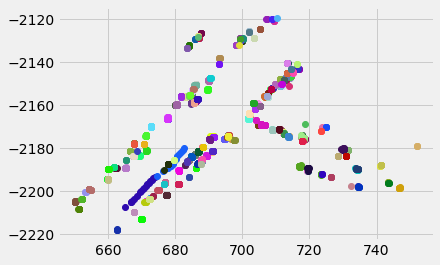

In [20]:
plotAgents(agents)

In [21]:
def normalizeAgents(agents):
    dataForNormalization = []
    pb = ProgressBar(len(agents))
    pb.start()
    for i in range(0, len(agents)):
        agent = agents[i]
        pb.check(i)
        for data in agent:
            for i in range(0, len(data)):
                feature = data[i]
                if i >= len(dataForNormalization):
                    dataForNormalization.append([])
                dataForNormalization[i].append(feature)
        
    
    first = True
    normalizedAgents = []
    pb = ProgressBar(len(dataForNormalization) * len(agents))
    counter = 0
    pb.start()
    for i in range(0, len(dataForNormalization)):
        pb.end()
        data = dataForNormalization[i]
        min_ = np.min(data)
        max_ = np.max(data)
        print("max[{}]".format(i),max_)
        print("min[{}]".format(i),min_,"\n")
        
        for j in range(0, len(agents)):
            counter = counter + 1
            pb.check(counter)
            if j >= len(normalizedAgents):
                normalizedAgents.append([])
                
            agent = agents[j]
            normalizedAgent = normalizedAgents[j]
            
            for k in range(0, len(agent)):
                if k >= len(normalizedAgent):
                    normalizedAgent.append([])
                data = agent[k]
                normalizedData = normalizedAgent[k]
                
                feature = data[i]
                normalizedFeature = (feature - min_) / (max_ - min_)
                if i == 0 and first:
                    print(feature)
                    print(normalizedFeature)
                    first = False
                
                if i >= len(normalizedData):
                    normalizedData.append(0)
                normalizedData[i] = normalizedFeature
    return normalizedAgents

In [22]:
import copy

In [23]:
normalizedAgents = normalizeAgents(agents)

101%  Remaining: 23:59:59  Elapsed: 00:00:00  Total: 00:00:00
max[0] 751.9480590820312
min[0] 650.2347412109375 

665.0342407226562
0.14550208194442027
 20%  Remaining: 00:00:00  Elapsed: 00:00:00  Total: 00:00:00
max[1] -2119.204345703125
min[1] -2217.884521484375 

 40%  Remaining: 00:00:00  Elapsed: 00:00:00  Total: 00:00:00
max[2] 2.9422047
min[2] -2.1619058 

 60%  Remaining: 00:00:00  Elapsed: 00:00:00  Total: 00:00:00
max[3] 8.2610235
min[3] -2.5182643 

 80%  Remaining: 00:00:00  Elapsed: 00:00:00  Total: 00:00:00
max[4] 9.853572
min[4] -2.238635 



In [24]:
print(len(agents))
print(len(normalizedAgents),"\n")

print(agents[0][0][0])
print(normalizedAgents[0][0][0],"\n")

225
225 

665.0342407226562
0.14550208194442027 



In [25]:
def printAgentsInfo(agents, limit):
    print("len(agents)", len(agents), "\n")

    agentCentroidLengths = []
    agentsOverLimit = []
    for agent in agents:
        agentCentroidLengths.append(len(agent))
        if len(agent) > limit:
            agentsOverLimit.append(agent)

    print("len(agentCentroidLengths)",len(agentCentroidLengths), "\n")

    print("max",np.max(agentCentroidLengths))
    print("min",np.min(agentCentroidLengths))
    print("mean",np.mean(agentCentroidLengths))
    print("std",np.std(agentCentroidLengths), "\n")

    print("agents with {}+ history".format(limit),len(agentsOverLimit))
    return agentsOverLimit

In [26]:
limit = 10
agentsOverLimit = printAgentsInfo(normalizedAgents, limit)

len(agents) 225 

len(agentCentroidLengths) 225 

max 26
min 0
mean 8.444444444444445
std 6.995730620427023 

agents with 10+ history 73


In [27]:
def getTrainingSets(agents, limit):
    allTrainingSets = []
    totalNumberOfTrainingSets = 0
    
    pb = ProgressBar(len(agentsOverLimit))
    pb.start()
    for i in range(0, len(agentsOverLimit)):
        agent = agentsOverLimit[i]
        agentTrainingSets = []
        for i in range(limit, len(agent)-1):
            agentTrainingSet = []

            start = i - limit
            end = i
            output = i + 1

            agentTrainingSet.append(agent[start:end])
            agentTrainingSet.append(agent[output])
            agentTrainingSets.append(agentTrainingSet)

            totalNumberOfTrainingSets = totalNumberOfTrainingSets + 1

        allTrainingSets.append(agentTrainingSets)
        pb.check(i)
    pb.end()
    
    print("len(allTrainingSets)", len(allTrainingSets))
    print("len(allTrainingSets[0])",len(allTrainingSets[0]), "\n")

    print("len(agentsOverLimit)",len(agentsOverLimit))
    print("len(agentsOverLimit[0]) - limit - 1",len(agentsOverLimit[0]) - limit - 1, "\n")

    print("totalNumberOfTrainingSets",totalNumberOfTrainingSets)
    return allTrainingSets, totalNumberOfTrainingSets

In [28]:
allTrainingSets, totalNumberOfTrainingSets = getTrainingSets(agentsOverLimit, limit)

100%  Remaining: 00:00:00  Elapsed: 00:00:00  Total: 00:00:00
len(allTrainingSets) 73
len(allTrainingSets[0]) 6 

len(agentsOverLimit) 73
len(agentsOverLimit[0]) - limit - 1 6 

totalNumberOfTrainingSets 459


In [29]:
print(len(allTrainingSets))
print(len(allTrainingSets[0]))
print(len(allTrainingSets[0][0]))
print(len(allTrainingSets[0][0][0]))
print(len(allTrainingSets[0][0][0][0]))

73
6
2
10
5


In [30]:
def flattenTrainingSets(allTrainingSets, totalNumberOfTrainingSets):
    allTrainingSetsFlattened_X = np.empty((totalNumberOfTrainingSets, limit, len(allTrainingSets[0][0][0][0])))
    allTrainingSetsFlattened_Y = np.empty((totalNumberOfTrainingSets, len(allTrainingSets[0][0][0][0])))
    count = 0
    for allTrainingSet in allTrainingSets:
        for trainingSet in allTrainingSet:
            allTrainingSetsFlattened_X[count] = np.array(trainingSet[0])
            allTrainingSetsFlattened_Y[count] = trainingSet[1]
            count = count + 1
    print("len(allTrainingSetsFlattened_X)", len(allTrainingSetsFlattened_X))
    return allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y

In [31]:
allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y = flattenTrainingSets(allTrainingSets, totalNumberOfTrainingSets)


length = len(allTrainingSetsFlattened_X)
depth = len(allTrainingSetsFlattened_X[0])
channels = len(allTrainingSetsFlattened_X[0][0])

print("length", length)
print("depth", depth)
print("channels",channels)
print("length*depth*channels",length*depth*channels)

allTrainingSetsFlattened_Input = allTrainingSetsFlattened_X
allTrainingSetsFlattened_Output = allTrainingSetsFlattened_Y

print(allTrainingSetsFlattened_Input.shape[1])
print(allTrainingSetsFlattened_Input.shape[2])

len(allTrainingSetsFlattened_X) 459
length 459
depth 10
channels 5
length*depth*channels 22950
10
5


In [32]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(allTrainingSetsFlattened_Input.shape[1],allTrainingSetsFlattened_Input.shape[2])))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=allTrainingSetsFlattened_Input.shape[2]))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [33]:
from tensorflow import keras

In [34]:
# Fitting to the training set

class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self):
        self.epoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Epoch: {}             loss: {}\n".format(self.epoch, logs['loss']), end="")
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        if batch % 100 == 0:
            print("Epoch: {} batchs: {}% loss: {}\r".format(self.epoch, round(batch / self.params['steps'] * 100), logs['loss']), end="")

regressor.fit(allTrainingSetsFlattened_Input,allTrainingSetsFlattened_Output,epochs=2,batch_size=128,verbose=0,callbacks=[CustomCallback()])

Epoch: 0             loss: 0.12282079458236694
Epoch: 0             loss: 0.024086182937026024


In [35]:
dataset_path_test = dm.require('scenes/test.zarr')
zarr_dataset_test = ChunkedDataset(dataset_path_test)
zarr_dataset_test.open()
print(zarr_dataset_test)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [36]:
print(len(zarr_dataset_test.agents))

88594921


In [66]:
subsetPercent = 1*10**-1
print(subsetPercent)
agentsTest = getAgentsChunked(zarr_dataset_test.agents, subsetPercent, 1000)

0.1


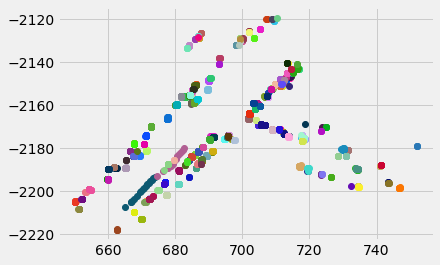

In [49]:
plotAgents(agents)

In [67]:
normalizedAgentsTest = normalizeAgents(agentsTest)

101%  Remaining: 00:00:00  Elapsed: 00:00:28  Total: 00:00:28
max[0] 1204.822998046875
min[0] -1133.8607177734375 

532.249755859375
0.7124137660694364
 20%  Remaining: 00:03:05  Elapsed: 00:00:46  Total: 00:03:52
max[1] 1640.85986328125
min[1] -2525.48681640625 

 40%  Remaining: 00:01:46  Elapsed: 00:01:10  Total: 00:02:57
max[2] 3.141592
min[2] -3.1415925 

 60%  Remaining: 00:01:04  Elapsed: 00:01:35  Total: 00:02:39
max[3] 38.246292
min[3] -40.707573 

 80%  Remaining: 00:00:30  Elapsed: 00:01:59  Total: 00:02:29
max[4] 55.803272
min[4] -39.218674 



In [68]:
agentsTestOverLimit = printAgentsInfo(normalizedAgentsTest, limit)

len(agents) 1206 

len(agentCentroidLengths) 1206 

max 89631
min 0
mean 7353.1169154228855
std 9727.51133188082 

agents with 10+ history 1166


In [69]:
allTestingSets, totalNumberOfTestingSets = getTrainingSets(agentsTestOverLimit, limit)

100%  Remaining: 23:59:59  Elapsed: 00:00:00  Total: 00:00:00
len(allTrainingSets) 73
len(allTrainingSets[0]) 6 

len(agentsOverLimit) 73
len(agentsOverLimit[0]) - limit - 1 6 

totalNumberOfTrainingSets 459


In [70]:
allTestingSetsFlattened_X, allTestingSetsFlattened_Y = flattenTrainingSets(allTestingSets, totalNumberOfTestingSets)

len(allTrainingSetsFlattened_X) 459


In [71]:
allTestingSetsFlattened_Input = allTestingSetsFlattened_X
allTestingSetsFlattened_Output = allTestingSetsFlattened_Y

In [72]:
print(allTestingSetsFlattened_Input.shape)

(459, 10, 5)


In [73]:
max = len(allTestingSetsFlattened_Input)
print(max)
chunkSize = 100
pb = ProgressBar(max)
pb.start()
predictedTestAgentCentroid = np.empty((1,5))
for i in range(0, max-chunkSize, chunkSize):#len(zarr_dataset.agents)):
    newPredictions = regressor.predict(allTestingSetsFlattened_Input[i:i+chunkSize])
    print(newPredictions.shape)
    predictedTestAgentCentroid = np.concatenate((predictedTestAgentCentroid, newPredictions))
    pb.check(i, True)

459


In [74]:
print(predictedTestAgentCentroid.shape)

(1, 5)


In [75]:
print(predictedTestAgentCentroid.shape)
predictedTestAgentCentroid = predictedTestAgentCentroid[1:len(predictedTestAgentCentroid)]
print(predictedTestAgentCentroid.shape)

(1, 5)
(0, 5)


In [76]:
print(len(predictedTestAgentCentroid))

0


In [77]:
randomSamples = 10
for i in range(0, len(predictedTestAgentCentroid), round(len(predictedTestAgentCentroid) / randomSamples)):
    testSet = allTestingSetsFlattened_Input[i]
    lastTestSet = testSet[len(testSet[0]) - 1][0]
    firstPrediction = predictedTestAgentCentroid[i][0]
    print(lastTestSet)
    print(firstPrediction,"\n")

ValueError: range() arg 3 must not be zero

In [ ]:
csv_path = "submission.csv"
testCSVOutput = np.empty((5,50,2))
print(testCSVOutput.shape)

In [ ]:
import os
os.remove(csv_path)

In [ ]:
file = open(csv_path, 'w')

def printCoord(row, axis, confidence, timestep):
    return row + "coord_" + axis + str(confidence) + str(timestep) + ","
    
# timestamp track_id conf_0 conf_1 conf_2	coord_x00 coord_y249
row = ""
row = row + "timestamp" + ","
row = row + "track_id" + ","
for i in range(0,3):
    row = row + "conf_" + str(i) + ","
for confidence in range(0,3):
    for timestep in range(0,50):
        row = printCoord(row, "x", confidence, timestep)
        row = printCoord(row, "y", confidence, timestep)
row = row + "\n"
print(row)
file.write(row)
file.close()